In [1]:
! pip install -q kaggle

In [45]:
from glob import glob
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import Imagedata_generatorerator
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#from tqdm import tqdm_notebook,trange
print("done import")

done import


In [3]:
from google.colab import files

files.upload()

dataset = 'histopathologic-cancer-detection'

!rm -r $dataset

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c $dataset

zip_file = f"{dataset}.zip"
destination_dir = f"/content/{dataset}"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

Saving kaggle.json to kaggle.json
rm: cannot remove 'histopathologic-cancer-detection': No such file or directory
rm: cannot remove '/root/.kaggle': No such file or directory
100% 6.30G/6.31G [00:51<00:00, 191MB/s]
100% 6.31G/6.31G [00:51<00:00, 133MB/s]


In [4]:
path = './histopathologic-cancer-detection/'
train_path = './histopathologic-cancer-detection/train/'
test_path = './histopathologic-cancer-detection/test/'

In [5]:
all_train_df = pd.read_csv(path+"train_labels.csv")
all_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
print("Train Size: {}".format(len(os.listdir(train_path))))
print("Test Size: {}".format(len(os.listdir(test_path))))

Train Size: 220025
Test Size: 57458


In [7]:
label_counts = all_train_df.label.value_counts()
print(label_counts)



label
0    130908
1     89117
Name: count, dtype: int64


In [49]:
all_train_df["id"] = all_train_df["id"].apply(lambda x: x + ".tif")
all_train_df["label"] = all_train_df["label"].astype(str)

In [60]:
data_generator = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)

In [61]:
train_data_generator = data_generator.flow_from_dataframe(
    dataframe=all_train_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=5,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.


In [62]:
val_data_generator = data_generator.flow_from_dataframe(
    dataframe=all_train_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=5,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 44005 validated image filenames belonging to 2 classes.


In [67]:


model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters=16, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(1, activation = "sigmoid"))

model.build(input_shape=(32, 64, 64, 3))

model.compile(Adam(0.001), loss = "binary_crossentropy", metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (32, 62, 62, 16)          448       
                                                                 
 batch_normalization_20 (Ba  (32, 62, 62, 16)          64        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (32, 62, 62, 16)          0         
                                                                 
 conv2d_23 (Conv2D)          (32, 60, 60, 16)          2320      
                                                                 
 batch_normalization_21 (Ba  (32, 60, 60, 16)          64        
 tchNormalization)                                               
                                                                 
 activation_13 (Activation)  (32, 60, 60, 16)         

In [68]:
detection_cnn = model.fit(
                        train_data_generator,
                        steps_per_epoch=650,
                        epochs=5,
                        validation_data=val_data_generator,
                        validation_steps=170,
                        verbose=1)

Epoch 1/5
650/650 [==============================] - 148s 223ms/step - loss: 0.3909 - accuracy: 0.8306 - val_loss: 0.3826 - val_accuracy: 0.8338
Epoch 2/5
650/650 [==============================] - 149s 230ms/step - loss: 0.3279 - accuracy: 0.8617 - val_loss: 0.3520 - val_accuracy: 0.8501
Epoch 3/5
650/650 [==============================] - 148s 228ms/step - loss: 0.2954 - accuracy: 0.8777 - val_loss: 0.3543 - val_accuracy: 0.8445
Epoch 4/5
650/650 [==============================] - 144s 221ms/step - loss: 0.2786 - accuracy: 0.8848 - val_loss: 1.6023 - val_accuracy: 0.6515
Epoch 5/5
650/650 [==============================] - 149s 229ms/step - loss: 0.2648 - accuracy: 0.8919 - val_loss: 0.8504 - val_accuracy: 0.7793


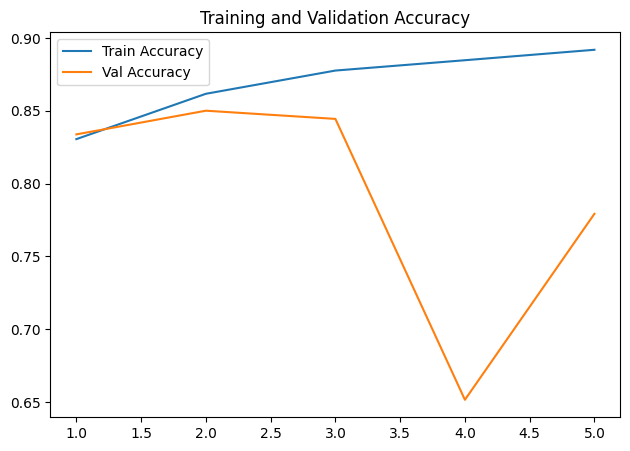

In [74]:
model_acc = detection_cnn.history['accuracy']
val_model_acc = detection_cnn.history['val_accuracy']

epochs = range(1,len(model_acc)+1)

# accuracy
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, model_acc, label='Train Accuracy')
plt.plot(epochs, val_model_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [72]:
print(epochs)

range(0, 5)


In [75]:
model.compile(Adam(0.0001), loss = "binary_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, None, None, 16)    448       
                                                                 
 batch_normalization_20 (Ba  (None, None, None, 16)    64        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, None, None, 16)    0         
                                                                 
 conv2d_23 (Conv2D)          (None, None, None, 16)    2320      
                                                                 
 batch_normalization_21 (Ba  (None, None, None, 16)    64        
 tchNormalization)                                               
                                                                 
 activation_13 (Activation)  (None, None, None, 16)   

In [76]:
detection_cnn = model.fit(
                        train_data_generator,
                        steps_per_epoch=650,
                        epochs=3,
                        validation_data=val_data_generator,
                        validation_steps=170,
                        verbose=1)

Epoch 1/3
650/650 [==============================] - 148s 223ms/step - loss: 0.2369 - accuracy: 0.9048 - val_loss: 0.2827 - val_accuracy: 0.8871
Epoch 2/3
650/650 [==============================] - 145s 223ms/step - loss: 0.2328 - accuracy: 0.9065 - val_loss: 0.2677 - val_accuracy: 0.8921
Epoch 3/3
650/650 [==============================] - 144s 221ms/step - loss: 0.2288 - accuracy: 0.9080 - val_loss: 0.3204 - val_accuracy: 0.8790


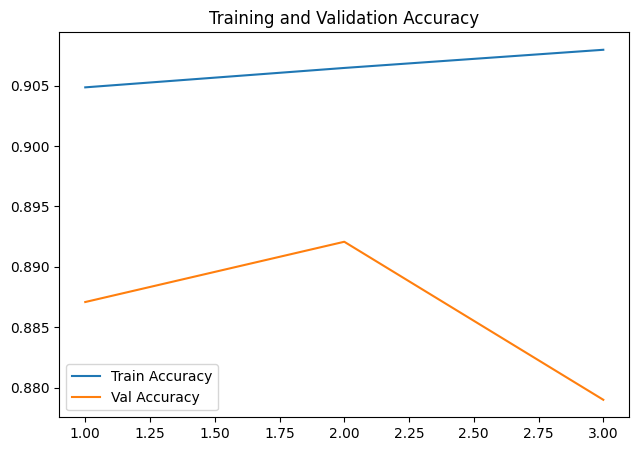

In [98]:
model_acc = detection_cnn.history['accuracy']
val_model_acc = detection_cnn.history['val_accuracy']

epochs = range(1,len(model_acc)+1)

# accuracy
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, model_acc, label='Train Accuracy')
plt.plot(epochs, val_model_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

## Predict on Test Data and Create Submission File

In [87]:
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

,id
0,e26a607c4b490b67a979d4f70a1b1939e068b5c3.tif
1,de9f8e5becbf0b2c2c6a6e707ba1ed5ef6df7ef3.tif
2,0c72b29dc06df71e5c63d6b3b3e9e1c807a560fa.tif
3,0a49770a30d2761103e69d2a9e70299c08a0a9a8.tif
4,a11eb4dc98c26b71e397b0a1c26cf3d1181bda74.tif


In [90]:
data_generator_test = ImageDataGenerator(rescale=1./255.)

test_data_generator = data_generator_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id',
    y_col=None,
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [92]:
results = model.predict(test_data_generator, verbose=1)

57458/57458 [==============================] - 140s 2ms/step


In [93]:
results = np.transpose(results)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, results))
submission_df.head()

,id,label
0,e26a607c4b490b67a979d4f70a1b1939e068b5c3,0
1,de9f8e5becbf0b2c2c6a6e707ba1ed5ef6df7ef3,0
2,0c72b29dc06df71e5c63d6b3b3e9e1c807a560fa,0
3,0a49770a30d2761103e69d2a9e70299c08a0a9a8,0
4,a11eb4dc98c26b71e397b0a1c26cf3d1181bda74,0


In [94]:
submission_df.to_csv('submission.csv', index=False)

In [97]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>